In [4]:
import random
import pathlib

In [9]:
# filename: validate_rag1_no_api_fixed.py

import os
import json
import time
import pandas as pd # Although not used in this specific version, good practice if extending
from typing import List, Dict, Any

# === LangChain & Related Imports ===
# (Make sure to have these installed: pip install langchain-huggingface faiss-cpu langchain-core langchain-community)
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_core.documents import Document
from langchain_community.docstore.in_memory import InMemoryDocstore # Needed for loading .pkl internals if required

# === Configuration (No API Key Needed) ===
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
K = 3 # Number of results to retrieve

# --- Attempt to load Embeddings ---
try:
    embeddings = HuggingFaceEmbeddings(model_name=MODEL_NAME)
    print(f"✅ Embedding model '{MODEL_NAME}' loaded successfully.")
except Exception as e:
    print(f"❌ ERROR: Failed to load embedding model: {e}")
    embeddings = None

# === Helper Functions ===

def load_retriever(faiss_index_folder_path: str, embeddings_model: object, k_results: int) -> object | None:
    """
    Loads a FAISS vector store and returns a retriever object.
    Expects the folder path containing 'index.faiss' and 'index.pkl'.
    """
    print(f"🔄 Attempting to load retriever from folder: {faiss_index_folder_path}")
    if not embeddings_model:
        print("❌ ERROR: Embeddings model not loaded. Cannot load retriever.")
        return None

    # Check if required files exist within the folder
    faiss_file = os.path.join(faiss_index_folder_path, "index.faiss")
    pkl_file = os.path.join(faiss_index_folder_path, "index.pkl") # Often implicitly loaded by FAISS.load_local

    if not os.path.exists(faiss_index_folder_path):
         print(f"❌ ERROR: Folder path not found: {faiss_index_folder_path}")
         return None
    if not os.path.exists(faiss_file): # Primarily check for faiss file, pkl is usually secondary
        print(f"❌ ERROR: 'index.faiss' not found inside folder: {faiss_index_folder_path}")
        return None
    # Add check for pkl if FAISS load fails without it, but often it's implicit
    if not os.path.exists(pkl_file):
         print(f"⚠️ WARNING: 'index.pkl' not found inside folder: {faiss_index_folder_path}. FAISS loading might fail.")


    try:
        # FAISS.load_local loads both .faiss and .pkl from the specified folder
        vectorstore = FAISS.load_local(
            faiss_index_folder_path,
            embeddings_model,
            allow_dangerous_deserialization=True # Necessary for loading LangChain objects
        )
        print("✅ FAISS index loaded successfully.")
        return vectorstore.as_retriever(search_kwargs={"k": k_results})
    except Exception as e:
        print(f"❌ ERROR loading FAISS index from {faiss_index_folder_path}: {e}")
        return None

# --- SIMULATED LLM Function (No API Call) ---
def llm_compare_and_critique_simulated(user_clause_text: str, ideal_context_docs: List[Document]) -> Dict:
    """
    SIMULATED: Returns a placeholder critique JSON without calling an external LLM API.
    """
    print(f"⚙️   SIMULATING LLM Critique for: {user_clause_text[:60]}...")
    # Basic simulation logic
    simulated_risk = "MEDIUM"
    lower_clause = user_clause_text.lower()
    if "without notice" in lower_clause or "at any time" in lower_clause:
        simulated_risk = "HIGH"
    elif "reasonable notice" in lower_clause or "prior appointment" in lower_clause and len(ideal_context_docs) > 0:
         simulated_risk = "LOW"
    elif len(ideal_context_docs) == 0:
        simulated_risk = "MEDIUM"

    return {
            "clause_summary": f"Simulated summary for clause: '{user_clause_text[:35]}...'",
            "risk_level": simulated_risk,
            "feedback": f"Simulated feedback. Retrieved {len(ideal_context_docs)} context chunks.",
            "suggestion": "Simulated suggestion. Review against standard templates."
           }

# --- Golden Set Loading Function ---
def load_golden_set(filepath: str) -> List[Dict]:
    """Loads a .jsonl file containing the golden set."""
    if not os.path.exists(filepath):
        print(f"⚠️ WARNING: Golden set file not found: {filepath}. Validation will be skipped or limited.")
        return []
    data = []
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            for line_num, line in enumerate(f, 1):
                try:
                    # Skip empty lines
                    if not line.strip():
                        continue
                    data.append(json.loads(line.strip()))
                except json.JSONDecodeError as json_err:
                    print(f"❌ ERROR parsing JSON on line {line_num} in {filepath}: {json_err}")
                    print(f"   Line content: {line.strip()}")
        print(f"✅ Loaded {len(data)} entries from {filepath}")
        return data
    except Exception as e:
        print(f"❌ ERROR reading golden set file {filepath}: {e}")
        return []

# === RAG 1 Validation Functions ===

def validate_rag1_retriever(retriever: object, golden_set: List[Dict], k_value: int):
    """Calculates Hit Rate@K and MRR for the RAG 1 retriever with path normalization."""
    print("\n" + "="*10 + " RAG 1 Retriever Validation " + "="*10)
    if not retriever:
        print(" RAG 1 Retriever not loaded. Skipping validation.")
        print("="*40)
        return {"hit_rate": 0, "mrr": 0}
    if not golden_set:
        print(" RAG 1 Golden Set is empty or not loaded. Skipping validation.")
        print("="*40)
        return {"hit_rate": 0, "mrr": 0}

    hits = 0
    reciprocal_ranks = []
    processed_items = 0

    for i, item in enumerate(golden_set):
        user_clause = item.get("user_clause")
        expected_sources_raw = item.get("expected_context_sources", [])
        if not isinstance(expected_sources_raw, (list, set)):
             print(f"   ⚠️ Skipping item {i+1}: 'expected_context_sources' is not a list/set.")
             continue
        # Normalize expected sources immediately
        normalized_expected_sources = set(src.replace("\\", "/") for src in expected_sources_raw)

        if not user_clause:
            print(f"   ⚠️ Skipping item {i+1}: missing 'user_clause'.")
            continue

        # Allow processing even if normalized_expected_sources is empty
        processed_items += 1
        print(f"   Processing item {i+1}/{len(golden_set)}...")
        try:
            retrieved_docs = retriever.invoke(user_clause)

            # === FIX: NORMALIZE RETRIEVED PATHS ===
            retrieved_sources_normalized = [
                doc.metadata.get("source", "UnknownSource").replace("\\", "/")
                for doc in retrieved_docs
            ]
            # ======================================

            hit_in_k = False
            first_hit_rank = 0
            # Check only up to K results
            for rank, source_norm in enumerate(retrieved_sources_normalized[:k_value], 1):
                # Compare normalized retrieved source with normalized expected sources
                if source_norm in normalized_expected_sources:
                    hit_in_k = True
                    if first_hit_rank == 0:
                        first_hit_rank = rank
                    # break # Uncomment if only the first hit within K matters

            if hit_in_k:
                hits += 1
            if first_hit_rank > 0:
                reciprocal_ranks.append(1 / first_hit_rank)
                print(f"     ✅ Hit found at rank {first_hit_rank}. Retrieved (Normalized): {retrieved_sources_normalized[:k_value]}")
            else:
                reciprocal_ranks.append(0)
                # If expected_sources was empty, this isn't technically a "miss" in the usual sense
                if not normalized_expected_sources:
                     print(f"     ℹ️ No hits expected and none found. Retrieved (Normalized): {retrieved_sources_normalized[:k_value]}")
                else:
                     print(f"     ❌ Miss. Expected (Normalized): {list(normalized_expected_sources)}, Retrieved (Normalized): {retrieved_sources_normalized[:k_value]}")


        except Exception as e:
            print(f"   ❌ ERROR processing item {i+1} for retriever validation: {e}")
            reciprocal_ranks.append(0) # Treat errors as misses for MRR calculation

    # --- Calculate and Print Metrics ---
    if processed_items == 0:
        print("\nNo valid items processed for RAG 1 Retriever validation.")
        hit_rate = 0.0
        mrr = 0.0
    else:
        hit_rate = (hits / processed_items) * 100
        mrr = sum(reciprocal_ranks) / processed_items

    print("\n--- RAG 1 Retriever Metrics ---")
    print(f"Total Valid Items Processed: {processed_items}")
    print(f"Hits@{k_value}: {hits}")
    print(f"Hit Rate@{k_value}: {hit_rate:.2f}%")
    print(f"MRR@{k_value}: {mrr:.4f}")
    print("="*40)
    return {"hit_rate": hit_rate, "mrr": mrr}

def validate_rag1_e2e_simulation(retriever: object, golden_set: List[Dict]):
    """Runs RAG 1 pipeline with SIMULATED LLM and saves results for review."""
    print("\n" + "="*10 + " RAG 1 E2E Simulation (No API) " + "="*10)
    if not retriever:
        print(" RAG 1 Retriever not loaded. Skipping E2E simulation.")
        print("="*48)
        return
    if not golden_set:
        print(" RAG 1 Golden Set is empty or not loaded. Skipping E2E simulation.")
        print("="*48)
        return

    results = []
    processed_items = 0

    for i, item in enumerate(golden_set):
        user_clause = item.get("user_clause")
        expected_critique = item.get("expected_critique") # Still load for reference
        if not user_clause:
            print(f"   ⚠️ Skipping item {i+1}: missing 'user_clause'.")
            continue

        processed_items +=1
        print(f"   Simulating E2E for item {i+1}/{len(golden_set)}...")
        try:
            # Run the pipeline with simulated LLM
            retrieved_docs = retriever.invoke(user_clause)
            # Use the SIMULATED function
            simulated_critique = llm_compare_and_critique_simulated(user_clause, retrieved_docs)

             # Normalize retrieved sources for consistent reporting
            retrieved_sources_normalized = [
                doc.metadata.get("source", "UnknownSource").replace("\\", "/")
                for doc in retrieved_docs
            ]

            results.append({
                "item_index": i + 1,
                "user_clause": user_clause,
                "retrieved_context_sources_normalized": retrieved_sources_normalized,
                "simulated_critique": simulated_critique,
                "expected_critique": expected_critique # Include expected for manual comparison
            })
        except Exception as e:
             print(f"   ❌ ERROR simulating E2E for item {i+1}: {e}")


    print(f"\nGenerated SIMULATED critiques for {processed_items} items.")
    print("NOTE: LLM quality metrics (accuracy, faithfulness) are NOT calculated.")

    # --- Save results for manual review ---
    output_file = "rag1_e2e_simulation_results.jsonl"
    try:
        with open(output_file, "w", encoding='utf-8') as f:
           for res in results:
               # Use indent=2 for better readability if opening the file manually
               f.write(json.dumps(res, ensure_ascii=False, indent=2) + "\n")
        print(f"✅ Simulation results saved to {output_file} for manual review.")
    except Exception as e:
        print(f"❌ Error saving simulation results to {output_file}: {e}")

    print("="*48)


# === Main Execution ===
if __name__ == "__main__":
    print("🚀 Starting RAG 1 Validation Script (No API Key Mode)...")

    # --- Configuration ---
    # !! Adjust this path to the correct FOLDER containing index.faiss and index.pkl !!
    RAG1_INDEX_FOLDER = "./faiss_index_ideal_clauses"
    # !! Ensure this file exists and is correctly formatted (JSON Lines) !!
    # !! Make sure paths inside use FORWARD SLASHES ('/') for consistency !!
    RAG1_GOLDEN_SET_FILE = "validation_set_rag1_manual_input.jsonl"

    # --- Load Retriever ---
    rag1_retriever = None
    if embeddings:
        rag1_retriever = load_retriever(RAG1_INDEX_FOLDER, embeddings, K)
    else:
        print("❌ Embeddings failed to load, cannot proceed.")

    # --- Load Golden Set ---
    rag1_golden_set = load_golden_set(RAG1_GOLDEN_SET_FILE)

    # --- Run Validations ---
    if rag1_retriever and rag1_golden_set:
        print("\n🏁 Running RAG 1 Validations...")
        # 1. Validate the retriever component (with path fix)
        retriever_metrics = validate_rag1_retriever(rag1_retriever, rag1_golden_set, K)

        # 2. Run the E2E simulation (uses simulated LLM)
        validate_rag1_e2e_simulation(rag1_retriever, rag1_golden_set)
    else:
        print("\n⚠️ Skipping validations due to issues loading retriever or golden set.")

    print("\n🏁 Validation script finished.")

✅ Embedding model 'sentence-transformers/all-MiniLM-L6-v2' loaded successfully.
🚀 Starting RAG 1 Validation Script (No API Key Mode)...
🔄 Attempting to load retriever from folder: ./faiss_index_ideal_clauses
✅ FAISS index loaded successfully.
✅ Loaded 2 entries from validation_set_rag1_manual_input.jsonl

🏁 Running RAG 1 Validations...

========== RAG 1 Retriever Validation ==========
   Processing item 1/2...
     ✅ Hit found at rank 2. Retrieved (Normalized): ['TA_template/Tenancy Agreement Template for HDB Flats.pdf', 'TA_template/Tenancy Agreement Template for Private Residential Property.pdf', 'TA_template/TA template.pdf']
   Processing item 2/2...
     ✅ Hit found at rank 1. Retrieved (Normalized): ['TA_template/Tenancy Agreement Template for Private Residential Property.pdf', 'TA_template/Tenancy Agreement Template for Private Residential Property.pdf', 'TA_template/Tenancy Agreement Template for Private Residential Property.pdf']

--- RAG 1 Retriever Metrics ---
Total Valid It

final

In [14]:
# filename: validate_rag1_only_no_api_excel_30_drafts_fixed.py

import os
import json
import time
import pandas as pd # Import pandas for Excel I/O
from typing import List, Dict, Any

# === LangChain & Related Imports ===
try:
    from langchain_huggingface import HuggingFaceEmbeddings
    from langchain_community.vectorstores import FAISS
    from langchain_core.documents import Document
    from langchain_community.docstore.in_memory import InMemoryDocstore # For loading pickle internals if required
    print("✅ LangChain libraries imported successfully.")
except ImportError as e:
    print(f"❌ ERROR: Failed to import LangChain libraries: {e}")
    print("   Please install them: pip install langchain-huggingface faiss-cpu langchain-core langchain-community pandas openpyxl")
    exit() # Exit if core libraries are missing

# === Configuration ===
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
K = 3 # Number of results to retrieve

# --- Attempt to load Embeddings ---
try:
    embeddings = HuggingFaceEmbeddings(model_name=MODEL_NAME)
    print(f"✅ Embedding model '{MODEL_NAME}' loaded successfully.")
except Exception as e:
    print(f"❌ ERROR: Failed to load embedding model: {e}")
    embeddings = None

# === Helper Functions ===

def load_retriever(faiss_index_folder_path: str, embeddings_model: object, k_results: int) -> object | None:
    """Loads a FAISS vector store and returns a retriever object."""
    print(f"🔄 Attempting to load retriever from folder: {faiss_index_folder_path}")
    if not embeddings_model: print("❌ ERROR: Embeddings model not loaded."); return None
    faiss_file = os.path.join(faiss_index_folder_path, "index.faiss")
    pkl_file = os.path.join(faiss_index_folder_path, "index.pkl")
    if not os.path.exists(faiss_index_folder_path) or not os.path.exists(faiss_file):
        print(f"❌ ERROR: Folder or 'index.faiss' not found in: {faiss_index_folder_path}"); return None
    if not os.path.exists(pkl_file): print(f"⚠️ WARNING: 'index.pkl' not found in {faiss_index_folder_path}.")
    try:
        vectorstore = FAISS.load_local(faiss_index_folder_path, embeddings_model, allow_dangerous_deserialization=True)
        print(f"✅ FAISS index loaded successfully from {faiss_index_folder_path}.")
        return vectorstore.as_retriever(search_kwargs={"k": k_results})
    except Exception as e: print(f"❌ ERROR loading FAISS index from {faiss_index_folder_path}: {e}"); return None

# --- SIMULATED LLM Function ---
def llm_compare_and_critique_simulated(user_clause_text: str, ideal_context_docs: List[Document]) -> Dict:
    """SIMULATED: Returns a placeholder critique JSON without calling an external LLM API."""
    simulated_risk = "MEDIUM"
    lower_clause = user_clause_text.lower()
    if "without notice" in lower_clause or "at any time" in lower_clause: simulated_risk = "HIGH"
    elif ("reasonable notice" in lower_clause or "prior appointment" in lower_clause) and ideal_context_docs: simulated_risk = "LOW"
    elif not ideal_context_docs: simulated_risk = "MEDIUM"
    return {"sim_clause_summary": f"Simulated summary for: '{user_clause_text[:35]}...'", "sim_risk_level": simulated_risk, "sim_feedback": f"Simulated feedback. Retrieved {len(ideal_context_docs)} contexts.", "sim_suggestion": "Simulated suggestion."}

# --- Golden Set Generation (30 DRAFT EXAMPLES for RAG 1 - BASED ON PROVIDED PDFs) ---
def generate_rag1_golden_set_examples(num_entries=30) -> List[Dict]:
    """
    Generates 30 DRAFT golden set entries with AI-generated examples based on provided PDFs.
    !! REQUIRES MANUAL REVIEW AND CORRECTION BY AN EXPERT !!
    """
    print(f"⚠️ Generating {num_entries} DRAFT examples for RAG 1 based on provided PDFs. Manual editing and expert review required.")
    # Use forward slashes for paths in expected_context_sources
    data = [
        { # 1. Security Deposit (Standard)
          "user_clause": "(a) To pay the equivalent of One (1) monthly rent as deposit... deposit shall be refundable free of interest within two (2) weeks from the end of the tenancy less deductions... Such deposit shall not be used to set off any rent in arrears.",
          "expected_context_sources": ["TA template.pdf", "Tenancy Agreement Template for Private Residential Property.pdf", "Tenancy Agreement Template for HDB Flats.pdf"],
          "expected_critique": {"clause_summary": "One month deposit, refundable within 2 weeks less deductions, cannot offset rent.", "risk_level": "LOW", "feedback": "Aligns well with standard template clauses regarding deposit amount, refund timeframe, interest, deductions, and non-offsetting.", "suggestion": "Standard and acceptable clause."}
        },
        { # 2. Security Deposit (Missing non-offsetting clause)
          "user_clause": "Upon execution hereof, Tenant shall deposit with Landlord SGD 4000 as security for performance. Said deposit shall be returned to Tenant without interest within fourteen (14) days after termination, less lawful deductions.",
          "expected_context_sources": ["Tenancy Agreement Template for Private Residential Property.pdf", "Tenancy Agreement Template for HDB Flats.pdf"],
          "expected_critique": {"clause_summary": "$4000 deposit refundable within 14 days, less deductions.", "risk_level": "LOW", "feedback": "Includes amount, timeframe, deduction right. Omits explicit non-offsetting clause found in templates.", "suggestion": "Consider adding 'Deposit shall not be utilised to set off rent' for clarity."}
        },
        { # 3. Landlord Entry (Unreasonable - 'any time')
          "user_clause": "Landlord reserves the right to enter the premises at any time for inspection or repairs.",
          "expected_context_sources": ["Tenancy Agreement Template for Private Residential Property.pdf", "Tenancy Agreement Template for HDB Flats.pdf", "TA template.pdf"],
          "expected_critique": {"clause_summary": "Allows Landlord entry 'at any time'.", "risk_level": "HIGH", "feedback": "Infringes tenant's quiet enjoyment. Templates require reasonable notice/prior appointment except emergencies.", "suggestion": "Negotiate to require reasonable prior notice (e.g., 'by prior appointment') for non-emergency entries."}
        },
        { # 4. Landlord Entry (Reasonable - 'prior appointment')
          "user_clause": "The Tenant shall permit the Landlord... at all reasonable times by prior appointment to enter the said Premises... to view the condition... or to do repairs.",
          "expected_context_sources": ["Tenancy Agreement Template for Private Residential Property.pdf", "Tenancy Agreement Template for HDB Flats.pdf"],
          "expected_critique": {"clause_summary": "Allows Landlord entry at reasonable times by prior appointment.", "risk_level": "LOW", "feedback": "Aligns with standard templates requiring 'reasonable times' and 'prior appointment', respecting quiet enjoyment.", "suggestion": "Standard and acceptable."}
        },
        { # 5. Minor Repairs (Tenant Low Limit - $100)
          "user_clause": "Tenant responsible for minor repairs up to S$100 per item. Above this, Landlord pays balance unless damage due to Tenant negligence.",
          "expected_context_sources": ["Tenancy Agreement Template for Private Residential Property.pdf", "Tenancy Agreement Template for HDB Flats.pdf"],
          "expected_critique": {"clause_summary": "Tenant repairs up to $100/item.", "risk_level": "LOW", # Favourable to tenant
          "feedback": "Clear threshold ($100), lower than typical template range ($150-$XXX). Includes negligence exception.", "suggestion": "Acceptable, favourable to tenant."}
        },
        { # 6. Minor Repairs (Missing Negligence Clause for Excess)
          "user_clause": "Tenant pays for repairs up to $200. Cost above $200 fully borne by Landlord.",
          "expected_context_sources": ["Tenancy Agreement Template for Private Residential Property.pdf", "Tenancy Agreement Template for HDB Flats.pdf"],
          "expected_critique": {"clause_summary": "Tenant pays up to $200, Landlord pays all excess.", "risk_level": "MEDIUM", # Risk for landlord
          "feedback": "Clear threshold ($200). Omits standard condition that Landlord's excess payment is void if damage caused by Tenant's negligence.", "suggestion": "Landlord should add 'provided damage is not due to Tenant negligence or willful default'."}
        },
        { # 7. Pets (HDB - Strict No)
          "user_clause": "No dogs, cats, or pets allowed in the HDB flat.",
          "expected_context_sources": ["TA template.pdf", "Tenancy Agreement Template for HDB Flats.pdf"],
          "expected_critique": {"clause_summary": "Strictly prohibits pets in HDB flat.", "risk_level": "LOW", "feedback": "Clear prohibition. Aligns with template options and need for HDB compliance.", "suggestion": "Standard restrictive clause for HDB."}
        },
        { # 8. Pets (Private - Vague Consent)
          "user_clause": "Keeping of pets may be considered upon request.",
          "expected_context_sources": ["Tenancy Agreement Template for Private Residential Property.pdf"],
          "expected_critique": {"clause_summary": "Vaguely mentions pets might be considered.", "risk_level": "MEDIUM", "feedback": "Lacks clarity. Doesn't state consent must be written or if it can be withheld reasonably [compare cite: 3135]. Creates ambiguity.", "suggestion": "Clarify if allowed with *written* consent and if consent can/cannot be unreasonably withheld."}
        },
        { # 9. Subletting (Room Rental HDB - OK if landlord stays)
          "user_clause": "Tenant rents one bedroom and shall not assign or sublet the Room. Landlord confirms they continue residing in the flat.",
          "expected_context_sources": ["TA template.pdf"],
          "expected_critique": {"clause_summary": "Prohibits room subletting; confirms landlord resides.", "risk_level": "LOW", "feedback": "Standard for HDB room rental. Confirms landlord's stay, aligning with HDB rules.", "suggestion": "Necessary clauses for HDB room rental."}
        },
        { # 10. Subletting (Missing 'Unreasonably Withheld')
          "user_clause": "The Tenant shall not sublet, assign or part with the possession of the premises or any part thereof.",
          "expected_context_sources": ["Tenancy Agreement Template for Private Residential Property.pdf"],
          "expected_critique": {"clause_summary": "Absolute prohibition on subletting.", "risk_level": "LOW", # Slightly less tenant-friendly
          "feedback": "Provides maximum landlord control. Standard template suggests adding consent 'shall not be unreasonably withheld', making this stricter.", "suggestion": "Acceptable. Tenant might negotiate 'without Landlord's prior written consent, not unreasonably withheld'."}
        },
        { # 11. Termination (Rent Default - 7 days)
          "user_clause": "If rent is unpaid for seven (7) days after becoming due (whether formally demanded or not), Landlord may re-enter and terminate.",
          "expected_context_sources": ["TA template.pdf", "Tenancy Agreement Template for HDB Flats.pdf", "Tenancy Agreement Template for Private Residential Property.pdf"],
          "expected_critique": {"clause_summary": "Allows termination for 7-day rent default.", "risk_level": "LOW", "feedback": "Standard default period (7 days) found in templates. Clearly states demand not required.", "suggestion": "Common and acceptable."}
        },
        { # 12. Termination (Breach - 14 Day Remedy)
          "user_clause": "If Tenant breaches any condition and fails to rectify within 14 days of written notice, Landlord may terminate.",
          "expected_context_sources": ["Tenancy Agreement Template for HDB Flats.pdf", "Tenancy Agreement Template for Private Residential Property.pdf"],
          "expected_critique": {"clause_summary": "Termination allowed if breach not remedied after 14 days notice.", "risk_level": "LOW", "feedback": "Standard clause providing tenant reasonable time (14 days) to fix non-rent breaches after notice.", "suggestion": "Reasonable clause."}
        },
        { # 13. Diplomatic Clause (Standard 12+2)
          "user_clause": "After 12 months, if Tenant is posted out of Singapore or employment ceases, Tenant may terminate with 2 months' notice (or 2 months' rent in lieu), with proof.",
          "expected_context_sources": ["Tenancy Agreement Template for Private Residential Property.pdf", "Tenancy Agreement Template for HDB Flats.pdf"],
          "expected_critique": {"clause_summary": "Standard 12+2 diplomatic clause with proof needed.", "risk_level": "LOW", "feedback": "Typical terms (12 months min stay, 2 months notice/payment). Proof requirement is standard.", "suggestion": "Standard and acceptable."}
        },
        { # 14. Diplomatic Clause (Missing Proof)
          "user_clause": "Diplomatic clause applies after 1 year with 2 months notice if Tenant relocates.",
          "expected_context_sources": ["Tenancy Agreement Template for Private Residential Property.pdf", "Tenancy Agreement Template for HDB Flats.pdf"],
          "expected_critique": {"clause_summary": "Diplomatic clause (12+2) lacks explicit proof requirement.", "risk_level": "MEDIUM", "feedback": "Standard periods, but misses requiring documentary evidence (transfer letter) [compare cite: 2972, 221]. Can be abused.", "suggestion": "Add requirement for documentary proof of transfer/employment cessation."}
        },
        { # 15. Aircon Maintenance (Contract + Receipt Req)
          "user_clause": "Tenant must engage a contractor for quarterly aircon servicing at own expense and provide service contract copy and receipts.",
          "expected_context_sources": ["Tenancy Agreement Template for Private Residential Property.pdf", "Tenancy Agreement Template for HDB Flats.pdf"],
          "expected_critique": {"clause_summary": "Requires tenant contract for quarterly aircon service + proofs.", "risk_level": "LOW", "feedback": "Clearly outlines tenant duty for regular servicing via contract, frequency, cost, and proof (contract/receipts).", "suggestion": "Standard and well-defined."}
        },
        { # 16. Aircon Maintenance (Landlord Repairs unless Tenant Negligence)
          "user_clause": "Tenant services aircons quarterly. Landlord responsible for repairs/parts unless due to Tenant negligence or non-maintenance.",
          "expected_context_sources": ["Tenancy Agreement Template for Private Residential Property.pdf", "Tenancy Agreement Template for HDB Flats.pdf"],
          "expected_critique": {"clause_summary": "Tenant services quarterly, Landlord repairs unless tenant fault.", "risk_level": "LOW", "feedback": "Clear division: Tenant routine service, Landlord repairs/breakdowns (unless tenant's fault). Aligns with templates.", "suggestion": "Standard and fair."}
        },
        { # 17. Option to Renew (Rent Mutually Agreed)
          "user_clause": "Tenant may request renewal 2 months prior to expiry. Renewal subject to Landlord approval and mutual agreement on rent.",
          "expected_context_sources": ["Tenancy Agreement Template for Private Residential Property.pdf", "Tenancy Agreement Template for HDB Flats.pdf"],
          "expected_critique": {"clause_summary": "Option to renew with 2 months notice, rent to be mutually agreed.", "risk_level": "LOW", "feedback": "Includes notice period, landlord discretion, and standard requirement for mutual agreement on renewal rent.", "suggestion": "Standard approach."}
        },
        { # 18. Quiet Enjoyment (Present)
          "user_clause": "Tenant paying rent and observing covenants shall peaceably hold and enjoy the premises without interruption by Landlord.",
          "expected_context_sources": ["Tenancy Agreement Template for Private Residential Property.pdf", "Tenancy Agreement Template for HDB Flats.pdf", "TA template.pdf"],
          "expected_critique": {"clause_summary": "Guarantees tenant quiet enjoyment conditional on compliance.", "risk_level": "LOW", "feedback": "Standard and essential clause protecting tenant's right to occupy without unreasonable disturbance.", "suggestion": "Essential clause, looks good."}
        },
        { # 19. Utilities (Tenant Pays All)
          "user_clause": "Tenant shall be responsible for and pay all charges for water, electricity, gas, sewerage, and telecommunications services.",
          "expected_context_sources": ["Tenancy Agreement Template for Private Residential Property.pdf", "Tenancy Agreement Template for HDB Flats.pdf"],
          "expected_critique": {"clause_summary": "Tenant responsible for all utility and telecom payments.", "risk_level": "LOW", "feedback": "Clearly states tenant's responsibility for standard utilities and telecoms.", "suggestion": "Standard clause."}
        },
        { # 20. Furnishing (Unfurnished)
          "user_clause": "The premises are let on an unfurnished basis.",
          "expected_context_sources": ["Tenancy Agreement Template for Private Residential Property.pdf", "Tenancy Agreement Template for HDB Flats.pdf"],
          "expected_critique": {"clause_summary": "Specifies unfurnished condition.", "risk_level": "LOW", "feedback": "Clear statement of furnishing level. No inventory list typically needed unless specific landlord fixtures remain.", "suggestion": "Clear and acceptable if accurate."}
        },
         { # 21. Governing Law & Dispute (Arbitration)
          "user_clause": "Governed by Singapore Law. Any dispute shall be referred to arbitration in Singapore before legal action.",
          "expected_context_sources": ["Tenancy Agreement Template for Private Residential Property.pdf", "Tenancy Agreement Template for HDB Flats.pdf"],
          "expected_critique": {"clause_summary": "Singapore law applies; arbitration required before court.", "risk_level": "LOW", "feedback": "Standard governing law. Specifies arbitration as the first step for dispute resolution, an alternative to mediation mentioned in templates.", "suggestion": "Acceptable dispute resolution method, ensure parties understand implications of arbitration."}
        },
        { # 22. Smoking (Strict No)
          "user_clause": "Smoking is strictly prohibited within any part of the premises, including balconies or open areas.",
          "expected_context_sources": ["Tenancy Agreement Template for Private Residential Property.pdf", "Tenancy Agreement Template for HDB Flats.pdf"],
          "expected_critique": {"clause_summary": "Strictly prohibits smoking anywhere on premises.", "risk_level": "LOW", "feedback": "Comprehensive no-smoking clause covering all areas. Templates specify 'inside', this is broader.", "suggestion": "Clear, broad restriction."}
        },
        { # 23. Stamp Duty (Tenant Pays - Standard)
          "user_clause": "The stamp fees payable on this Agreement and duplicate thereof shall be borne by the Tenant.",
          "expected_context_sources": ["Tenancy Agreement Template for Private Residential Property.pdf", "Tenancy Agreement Template for HDB Flats.pdf", "TA template.pdf"],
          "expected_critique": {"clause_summary": "Tenant is responsible for paying stamp duty.", "risk_level": "LOW", "feedback": "Standard practice and aligns with default position in Stamp Duties Act. Explicitly stated.", "suggestion": "Standard practice."}
        },
        { # 24. Inventory List (Landlord Prepares)
          "user_clause": "Landlord shall prepare two copies of the Inventory List at commencement for Tenant's endorsement.",
          "expected_context_sources": ["Tenancy Agreement Template for Private Residential Property.pdf", "Tenancy Agreement Template for HDB Flats.pdf"],
          "expected_critique": {"clause_summary": "Landlord responsible for preparing inventory list for joint endorsement.", "risk_level": "LOW", "feedback": "Aligns perfectly with the procedure described in the templates. Ensures joint agreement on initial state.", "suggestion": "Standard and good practice."}
        },
        { # 25. Property Condition Report (Within Problem-Free Period)
          "user_clause": "Tenant warrants to prepare and submit the Property Condition Report within the Problem-Free Period stated in ITEM 19.",
          "expected_context_sources": ["Tenancy Agreement Template for Private Residential Property.pdf", "Tenancy Agreement Template for HDB Flats.pdf"],
          "expected_critique": {"clause_summary": "Tenant to submit condition report within the Problem-Free Period.", "risk_level": "LOW", "feedback": "Assigns responsibility to Tenant and links deadline to the defined Problem-Free Period, aligning with templates.", "suggestion": "Standard procedure as per templates."}
        },
        { # 26. Late Payment Interest (10% after 7 days)
          "user_clause": "In the event Rent remains unpaid 7 days after due date, Landlord may claim interest at 10% per annum on the unpaid amount.",
          "expected_context_sources": ["TA template.pdf", "Tenancy Agreement Template for Private Residential Property.pdf", "Tenancy Agreement Template for HDB Flats.pdf"],
          "expected_critique": {"clause_summary": "Charges 10% p.a. interest on late rent after 7 days.", "risk_level": "LOW", "feedback": "Standard grace period (7 days) and interest rate (10%) as mentioned or implied in templates.", "suggestion": "Common and acceptable."}
        },
        { # 27. Use of Premises (Illegal Activities Prohibited)
          "user_clause": "Tenant shall not use the Premises for any illegal purpose or activities of an improper nature.",
          "expected_context_sources": ["Tenancy Agreement Template for Private Residential Property.pdf", "Tenancy Agreement Template for HDB Flats.pdf"],
          "expected_critique": {"clause_summary": "Prohibits illegal or improper use of premises.", "risk_level": "LOW", "feedback": "Standard and essential clause preventing misuse of the property.", "suggestion": "Necessary clause."}
        },
        { # 28. Alterations (Holes need consent, except pictures)
          "user_clause": "Tenant must not hack holes or drive nails into walls/ceilings without prior written consent, except reasonably done to hang pictures where possible.",
          "expected_context_sources": ["Tenancy Agreement Template for Private Residential Property.pdf", "Tenancy Agreement Template for HDB Flats.pdf"],
          "expected_critique": {"clause_summary": "Prohibits holes/nails except for pictures, requires consent otherwise.", "risk_level": "LOW", "feedback": "Standard clause balancing landlord's property protection with tenant's convenience. Requires reinstatement.", "suggestion": "Reasonable clause."}
        },
        { # 29. Commission Refund (Tenant Terminates Early)
          "user_clause": "If Tenant lawfully terminates lease early (e.g. diplomatic clause), Tenant shall refund Landlord the pro-rata agent commission paid by Landlord. Landlord may deduct from deposit.",
          "expected_context_sources": ["TA template.pdf", "Tenancy Agreement Template for Private Residential Property.pdf", "Tenancy Agreement Template for HDB Flats.pdf"],
          "expected_critique": {"clause_summary": "Requires tenant refund pro-rata commission if tenant terminates early.", "risk_level": "LOW", "feedback": "Standard clause to protect landlord's commission expense upon valid early termination by tenant. Often requires proof of commission.", "suggestion": "Common clause. Tenant may ask for proof of commission amount."}
        },
        { # 30. Occupancy Limit (HDB Flat - Specific Names)
          "user_clause": "Only the following persons are permitted to stay in the HDB Room: [Name 1, NRIC], [Name 2, FIN]. Tenant must notify Landlord immediately of any changes.",
          "expected_context_sources": ["TA template.pdf"], # Room rental specific
          "expected_critique": {"clause_summary": "Lists specific permitted occupants for HDB room and requires notification of changes.", "risk_level": "LOW", "feedback": "Crucial for HDB compliance. Lists authorized occupants and requires notification of changes as per template.", "suggestion": "Essential for HDB room rentals."}
        }
    ]
    # Ensure we return exactly num_entries
    print(f"Generated {len(data)} DRAFT examples structure.")
    return data[:num_entries] if len(data) >= num_entries else data

# --- Golden Set Loading/Saving Functions ---
def load_golden_set_from_excel(filepath: str) -> List[Dict]:
    """Loads RAG 1 Golden Set data from an Excel file."""
    print(f"🔄 Attempting to load RAG 1 Golden Set from Excel: {filepath}")
    if not os.path.exists(filepath):
        print(f"⚠️ WARNING: Excel Golden Set file not found: {filepath}. Will generate placeholders if needed.")
        return []
    try:
        df = pd.read_excel(filepath, engine='openpyxl')
        df = df.fillna('') # Handle empty cells gracefully
        golden_data = df.to_dict('records')

        # Reconstruct critique dictionary & normalize sources
        for item in golden_data:
            item["expected_critique"] = {
                "clause_summary": item.pop("exp_clause_summary", ""),
                "risk_level": item.pop("exp_risk_level", ""),
                "feedback": item.pop("exp_feedback", ""),
                "suggestion": item.pop("exp_suggestion", "")
            }
            sources = item.get("expected_context_sources", "")
            if isinstance(sources, str):
                item["expected_context_sources"] = [s.strip().replace("\\", "/") for s in sources.split(';') if s.strip()]
            elif isinstance(sources, (list, set)):
                 item["expected_context_sources"] = [str(s).strip().replace("\\", "/") for s in sources if s]
            else:
                 item["expected_context_sources"] = []

        print(f"✅ Loaded {len(golden_data)} RAG 1 entries from {filepath}")
        return golden_data
    except ImportError: print("❌ ERROR: 'pandas'/'openpyxl' needed. Install: pip install pandas openpyxl"); return []
    except Exception as e: print(f"❌ ERROR reading Excel RAG 1 Golden Set {filepath}: {e}"); return []

def save_golden_set_to_excel(data: List[Dict], filepath: str):
    """Saves the RAG 1 golden set data list to an Excel file, flattening critique."""
    print(f"\n🔄 Preparing data to save/update RAG 1 Excel template: {filepath}")
    if not data: print("❌ No data provided."); return

    flattened_data = []
    for entry in data:
        sources_list = entry.get("expected_context_sources", [])
        if not isinstance(sources_list, list): sources_list = []
        flat_entry = {"user_clause": entry.get("user_clause", ""), "expected_context_sources": "; ".join(sources_list)}
        critique_dict = entry.get("expected_critique", {})
        flat_entry["exp_clause_summary"] = critique_dict.get("clause_summary", ""); flat_entry["exp_risk_level"] = critique_dict.get("risk_level", ""); flat_entry["exp_feedback"] = critique_dict.get("feedback", ""); flat_entry["exp_suggestion"] = critique_dict.get("suggestion", "")
        flattened_data.append(flat_entry)
    column_order = ["user_clause", "expected_context_sources", "exp_clause_summary", "exp_risk_level", "exp_feedback", "exp_suggestion"]

    try:
        df = pd.DataFrame(flattened_data); df = df.reindex(columns=column_order, fill_value=''); df.to_excel(filepath, index=False, engine='openpyxl')
        print(f"✅ RAG 1 Excel DRAFT/template saved/updated: '{filepath}'. Please review/edit.")
    except ImportError: print("❌ ERROR: 'pandas'/'openpyxl' not found."); print("   Install: pip install pandas openpyxl")
    except Exception as e: print(f"❌ Error saving RAG 1 template to {filepath}: {e}")

# === RAG 1 Validation Functions ===
def validate_rag1_retriever(retriever: object, golden_set: List[Dict], k_value: int):
    """Calculates Hit Rate@K and MRR for RAG 1 retriever using basename comparison."""
    # (Includes basename comparison fix)
    print("\n" + "="*10 + " RAG 1 Retriever Validation " + "="*10)
    if not retriever: print(" Retriever not loaded. Skipping."); print("="*40); return {"hit_rate": 0, "mrr": 0}
    if not golden_set: print(" Golden Set empty/not loaded. Skipping."); print("="*40); return {"hit_rate": 0, "mrr": 0}
    hits, reciprocal_ranks, processed_items = 0, [], 0
    for i, item in enumerate(golden_set):
        user_clause = item.get("user_clause")
        expected_sources_raw = item.get("expected_context_sources", [])
        if not isinstance(expected_sources_raw, (list, set)): print(f"   ⚠️ Skipping item {i+1}: 'expected_context_sources' not list/set after load."); continue
        normalized_expected_basenames = set(os.path.basename(str(src).replace("\\", "/")) for src in expected_sources_raw if src)
        if not user_clause: print(f"   ⚠️ Skipping item {i+1}: missing 'user_clause'."); continue
        processed_items += 1
        try:
            retrieved_docs = retriever.invoke(user_clause)
            retrieved_basenames = [os.path.basename(doc.metadata.get("source", "UnknownSource").replace("\\", "/")) for doc in retrieved_docs]
            hit_in_k, first_hit_rank = False, 0
            for rank, basename in enumerate(retrieved_basenames[:k_value], 1):
                if basename in normalized_expected_basenames:
                    hit_in_k = True
                    if first_hit_rank == 0: first_hit_rank = rank
            if hit_in_k: hits += 1
            if first_hit_rank > 0: reciprocal_ranks.append(1 / first_hit_rank)
            else: reciprocal_ranks.append(0)
            if first_hit_rank == 0 and normalized_expected_basenames: print(f"     ❌ R1 Miss item {i+1}. Expected Basenames: {list(normalized_expected_basenames)}, Got Basenames: {retrieved_basenames[:k_value]}")
        except Exception as e: print(f"   ❌ ERROR processing RAG 1 item {i+1}: {e}"); reciprocal_ranks.append(0)
    if processed_items == 0: print("\nNo valid items processed."); hit_rate, mrr = 0.0, 0.0
    else: hit_rate, mrr = (hits / processed_items) * 100, sum(reciprocal_ranks) / processed_items
    print(f"\n--- RAG 1 Retriever Metrics ({processed_items} items) ---"); print(f"Hits@{k_value}: {hits}, Hit Rate: {hit_rate:.2f}%, MRR: {mrr:.4f}"); print("="*40)
    return {"hit_rate": hit_rate, "mrr": mrr}

def validate_rag1_e2e_simulation_excel(retriever: object, golden_set: List[Dict], output_filepath: str):
    """Runs RAG 1 pipeline with SIMULATED LLM and saves results to EXCEL."""
    print("\n" + "="*10 + " RAG 1 E2E Simulation (Excel Output) " + "="*10)
    if not retriever: print(" RAG 1 Retriever not loaded. Skipping."); print("="*52); return
    if not golden_set: print(" RAG 1 Golden Set empty/not loaded. Skipping."); print("="*52); return
    results_list, processed_items = [], 0
    print(f"Simulating E2E for {len(golden_set)} RAG 1 items...")
    for i, item in enumerate(golden_set):
        user_clause = item.get("user_clause")
        expected_critique_dict = item.get("expected_critique", {})
        if not user_clause: print(f"   ⚠️ Skipping item {i+1}: missing 'user_clause'."); continue
        processed_items += 1
        try:
            retrieved_docs = retriever.invoke(user_clause)
            simulated_critique_dict = llm_compare_and_critique_simulated(user_clause, retrieved_docs)
            retrieved_sources_normalized = [doc.metadata.get("source", "UnknownSource").replace("\\", "/") for doc in retrieved_docs]
            sources_list = item.get("expected_context_sources", []) # Get expected sources for the results file
            if not isinstance(sources_list, list): sources_list = []

            results_list.append({
                "item_index": i + 1, "user_clause": user_clause,
                "retrieved_sources": "; ".join(retrieved_sources_normalized), # Retrieved sources
                "expected_sources": "; ".join(sources_list), # Expected sources from Golden Set
                "sim_summary": simulated_critique_dict.get("sim_clause_summary"),
                "sim_risk": simulated_critique_dict.get("sim_risk_level"),
                "sim_feedback": simulated_critique_dict.get("sim_feedback"),
                "sim_suggestion": simulated_critique_dict.get("sim_suggestion"),
                "expected_summary": expected_critique_dict.get("clause_summary"),
                "expected_risk": expected_critique_dict.get("risk_level"),
                "expected_feedback": expected_critique_dict.get("feedback"),
                "expected_suggestion": expected_critique_dict.get("suggestion")
            })
        except Exception as e: print(f"   ❌ ERROR simulating RAG 1 E2E for item {i+1}: {e}")
    print(f"\nGenerated SIMULATED critiques for {processed_items} items.")
    print("NOTE: LLM quality metrics not calculated.")
    if results_list:
        try:
            df = pd.DataFrame(results_list)
            excel_column_order = ["item_index", "user_clause", "sim_summary", "expected_summary", "sim_risk", "expected_risk", "sim_feedback", "expected_feedback", "sim_suggestion", "expected_suggestion", "retrieved_sources", "expected_sources"]
            df = df.reindex(columns=excel_column_order, fill_value='')
            df.to_excel(output_filepath, index=False, engine='openpyxl')
            print(f"✅ RAG 1 Simulation results saved to {output_filepath}")
        except ImportError: print("❌ ERROR: 'pandas'/'openpyxl' not found."); print("   Install: pip install pandas openpyxl")
        except Exception as e: print(f"❌ Error saving RAG 1 results to {output_filepath}: {e}")
    else: print("No RAG 1 results to save.")
    print("="*52)

# === Main Execution ===
if __name__ == "__main__":
    print("🚀 Starting RAG 1 ONLY Validation Script (No API Key, Excel I/O, 30 Draft Examples)...")

    # --- Configuration ---
    RAG1_INDEX_FOLDER = "./faiss_index_ideal_clauses"
    RAG1_GOLDEN_SET_EXCEL = "rag1_golden_set_30_examples_DRAFT.xlsx" # Input/Output Excel for Golden Set
    RAG1_RESULTS_EXCEL = "rag1_simulation_results_30.xlsx" # Output Excel for results
    NUM_EXAMPLES = 30 # Number of examples to generate if file not found

    # --- Load Retriever ---
    rag1_retriever = None
    if embeddings:
        rag1_retriever = load_retriever(RAG1_INDEX_FOLDER, embeddings, K)
    else:
        print("❌ Embeddings failed to load, cannot proceed.")

    # --- Load or Generate Golden Set ---
    rag1_golden_set = load_golden_set_from_excel(RAG1_GOLDEN_SET_EXCEL)
    if not rag1_golden_set:
        print(f"⚠️ Generating {NUM_EXAMPLES} RAG 1 DRAFT examples.")
        rag1_golden_set = generate_rag1_golden_set_examples(NUM_EXAMPLES) # Generate draft examples
        save_golden_set_to_excel(rag1_golden_set, RAG1_GOLDEN_SET_EXCEL) # Save draft to Excel
        print(f"-> DRAFT data saved to '{RAG1_GOLDEN_SET_EXCEL}'. Requires manual review and correction!")

    # --- Run Validations ---
    print("\n" + "#"*10 + " STARTING RAG 1 VALIDATIONS " + "#"*10)
    if rag1_retriever and rag1_golden_set:
        print(f"Using {len(rag1_golden_set)} test cases for validation.")
        # 1. Validate the retriever component
        retriever_metrics = validate_rag1_retriever(rag1_retriever, rag1_golden_set, K)

        # 2. Run the E2E simulation and save to Excel
        validate_rag1_e2e_simulation_excel(rag1_retriever, rag1_golden_set, RAG1_RESULTS_EXCEL)
    else:
        print("\n⚠️ Skipping RAG 1 validations due to loading issues.")

    print("\n🏁 RAG 1 Validation script finished.")
    print(f"📊 RAG 1 simulation results saved to: {RAG1_RESULTS_EXCEL}")
    print(f"📝 Review/Edit RAG 1 Golden Set DRAFT/template: {RAG1_GOLDEN_SET_EXCEL}")

✅ LangChain libraries imported successfully.
✅ Embedding model 'sentence-transformers/all-MiniLM-L6-v2' loaded successfully.
🚀 Starting RAG 1 ONLY Validation Script (No API Key, Excel I/O, 30 Draft Examples)...
🔄 Attempting to load retriever from folder: ./faiss_index_ideal_clauses
✅ FAISS index loaded successfully from ./faiss_index_ideal_clauses.
🔄 Attempting to load RAG 1 Golden Set from Excel: rag1_golden_set_30_examples_DRAFT.xlsx
✅ Loaded 30 RAG 1 entries from rag1_golden_set_30_examples_DRAFT.xlsx

########## STARTING RAG 1 VALIDATIONS ##########
Using 30 test cases for validation.

========== RAG 1 Retriever Validation ==========

--- RAG 1 Retriever Metrics (30 items) ---
Hits@3: 30, Hit Rate: 100.00%, MRR: 1.0000

========== RAG 1 E2E Simulation (Excel Output) ==========
Simulating E2E for 30 RAG 1 items...

Generated SIMULATED critiques for 30 items.
NOTE: LLM quality metrics not calculated.
✅ RAG 1 Simulation results saved to rag1_simulation_results_30.xlsx

🏁 RAG 1 Validat

🚀 Starting RAG 1 Results Visualization Script...
🔄 Loading data from 'rag1_simulation_results_30.xlsx'...
✅ Data loaded (30 rows).

📊 Creating Visualizations...
   -> Heatmap saved as risk_comparison_heatmap.png
   -> Bar chart saved as risk_distribution_barchart.png

🏁 Visualization script finished.
   Check for 'risk_comparison_heatmap.png' and 'risk_distribution_barchart.png'


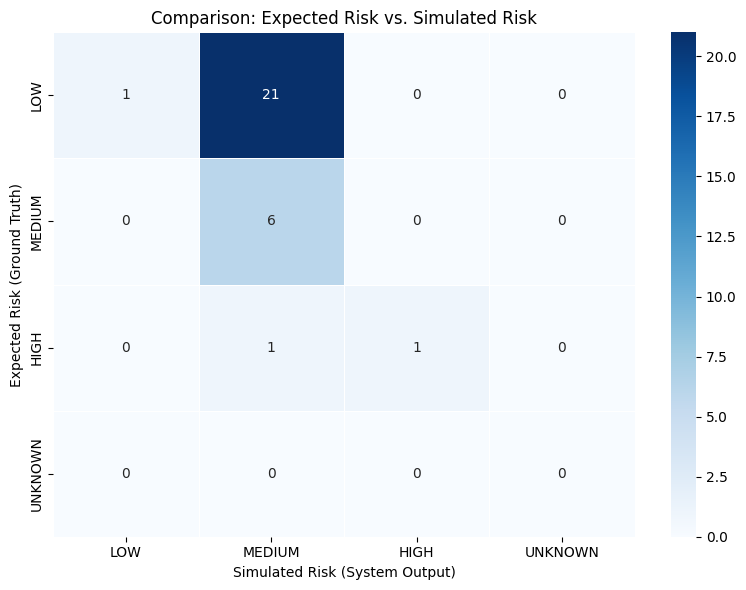

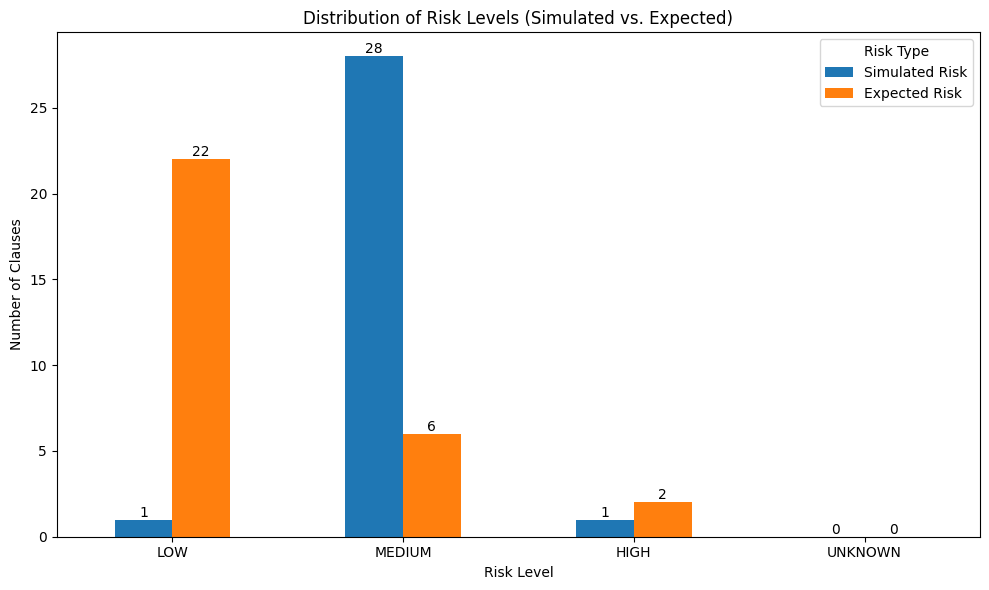

In [16]:
# filename: visualize_rag1_results.py

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # For heatmap
import os

# --- Configuration ---
EXCEL_RESULTS_FILE = "rag1_simulation_results_30.xlsx" # Input file
RISK_LEVELS = ['LOW', 'MEDIUM', 'HIGH', 'UNKNOWN'] # Order for plots (ensure UNKNOWN is uppercase like fillna output)

# --- Function to Load Data ---
def load_results_data(filepath: str) -> pd.DataFrame | None:
    """Loads simulation results from Excel."""
    print(f"🔄 Loading data from '{filepath}'...")
    if not os.path.exists(filepath):
        print(f"❌ ERROR: File not found: '{filepath}'"); return None
    try:
        df = pd.read_excel(filepath, engine='openpyxl')
        # Replace empty/NaN with 'UNKNOWN' (uppercase)
        df = df.fillna('UNKNOWN')
        print(f"✅ Data loaded ({len(df)} rows).")
        if 'sim_risk' not in df.columns or 'expected_risk' not in df.columns:
             print("❌ ERROR: 'sim_risk' or 'expected_risk' columns missing."); return None
        # Ensure consistency (string, uppercase)
        df['sim_risk'] = df['sim_risk'].astype(str).str.upper()
        df['expected_risk'] = df['expected_risk'].astype(str).str.upper()
        return df
    except ImportError: print("❌ ERROR: Install pandas & openpyxl: pip install pandas openpyxl"); return None
    except Exception as e: print(f"❌ ERROR loading Excel: {e}"); return None

# --- Function to Create Visualizations ---
def plot_risk_comparison(df: pd.DataFrame):
    """Creates heatmap and bar chart for risk comparison."""
    if df is None or df.empty: print("⚠️ No data to visualize."); return

    print("\n📊 Creating Visualizations...")

    # 1. Heatmap (Comparison Matrix)
    try:
        # Create comparison matrix using crosstab
        comparison_matrix = pd.crosstab(df['expected_risk'], df['sim_risk'])
        # Ensure all levels are present and ordered
        comparison_matrix = comparison_matrix.reindex(index=RISK_LEVELS, columns=RISK_LEVELS, fill_value=0)

        plt.figure(figsize=(8, 6))
        sns.heatmap(comparison_matrix, annot=True, fmt='d', cmap='Blues', linewidths=.5)
        plt.title('Comparison: Expected Risk vs. Simulated Risk')
        plt.ylabel('Expected Risk (Ground Truth)')
        plt.xlabel('Simulated Risk (System Output)')
        plt.tight_layout()
        plt.savefig("risk_comparison_heatmap.png") # Save the plot
        print("   -> Heatmap saved as risk_comparison_heatmap.png")
    except Exception as e: print(f"   ❌ Failed to create heatmap: {e}")

    # 2. Bar Chart (Distribution Comparison)
    try:
        # Count occurrences for each risk level
        sim_counts = df['sim_risk'].value_counts().reindex(RISK_LEVELS, fill_value=0)
        exp_counts = df['expected_risk'].value_counts().reindex(RISK_LEVELS, fill_value=0)
        # Combine counts into a DataFrame for plotting
        counts_df = pd.DataFrame({'Simulated Risk': sim_counts, 'Expected Risk': exp_counts})

        ax = counts_df.plot(kind='bar', figsize=(10, 6), rot=0)
        plt.title('Distribution of Risk Levels (Simulated vs. Expected)')
        plt.xlabel('Risk Level')
        plt.ylabel('Number of Clauses')
        plt.legend(title='Risk Type')
        plt.tight_layout()
        # Add count labels above bars
        for container in ax.containers: ax.bar_label(container)
        plt.savefig("risk_distribution_barchart.png") # Save the plot
        print("   -> Bar chart saved as risk_distribution_barchart.png")
    except Exception as e: print(f"   ❌ Failed to create bar chart: {e}")

    # Display plots if possible (might not work in all environments)
    # try:
    #     if plt.get_fignums(): plt.show()
    # except Exception as e:
    #     print(f"   ℹ️ Note: Could not display plots interactively ({e}). Check saved image files.")


# --- Main Execution ---
if __name__ == "__main__":
    print("🚀 Starting RAG 1 Results Visualization Script...")
    results_dataframe = load_results_data(EXCEL_RESULTS_FILE)
    if results_dataframe is not None:
        plot_risk_comparison(results_dataframe)
    else:
        print("\n⚠️ Cannot create visualizations.")
    print("\n🏁 Visualization script finished.")
    print("   Check for 'risk_comparison_heatmap.png' and 'risk_distribution_barchart.png'")